# QPAM

## Importing

In [1]:
#Importing
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa
import sounddevice as sd
from scipy.signal import savgol_filter

%matplotlib inline

##  Input and Preprocessing

In [43]:
#Option 1 : If extracting amplitudes from audio
filename = 'speech/Happy.wav' 
signal, sr = librosa.load(filename, sr=None)

# Normalize signal to range [-1, 1]
signal = signal / np.max(np.abs(signal))
num_samples = int(sr/2)

# Downsample or truncate the signal to the desired length 
if len(signal) > num_samples:
    sampled_signal = signal[:num_samples]
else:
    # Pad with zeros if less than the required samples
    sampled_signal = np.pad(signal, (0, num_samples - len(signal)))
    
a = sampled_signal 
    
#Option 2 : If giving manual inputs
#a = np.array([-0.8, -0.2, 0.0, 0.6, 1.0, -0.9, 0.53, 0.01])
#num_samples = len(a)

# Step 1: Add 1 to all amplitudes
a_shifted = a + 1

# Step 2: Divide all amplitudes by 2
b = a_shifted / 2

# Step 3: Normalize such that the sum is 1
g = np.sum(b)
c = b / g

# Step 4: Take square roots to get the probability amplitudes
alpha = np.sqrt(c)

# Pad `alpha` to the nearest power of 2
n_qubits = int(np.ceil(np.log2(len(alpha))))  # Number of qubits needed
padded_length = 2**n_qubits  # Next power of 2
padded_alpha = np.zeros(padded_length)
padded_alpha[:len(alpha)] = alpha

# Normalize `padded_alpha` explicitly
norm_factor = np.sqrt(np.sum(padded_alpha**2))
padded_alpha /= norm_factor

# Verify normalization
norm = np.sum(padded_alpha**2)
print(f"Amplitudes from audio: {a}")
print(f"Padded Probability amplitudes (α_i): {padded_alpha}")
print(f"Normalized sum of squares (should be 1): {norm}")

Amplitudes from audio: [ 0.0329184   0.04149378  0.0439834  ... -0.03070539 -0.0340249
 -0.0384509 ]
Padded Probability amplitudes (α_i): [0.00684466 0.00687301 0.00688122 ... 0.         0.         0.        ]
Normalized sum of squares (should be 1): 1.0


### QPAM Preparation

In [49]:
# Initialize quantum circuit
qc = QuantumCircuit(n_qubits)

# Initialize the state
qc.initialize(padded_alpha, range(n_qubits))

In [50]:
qc.measure_all()

# Use the Qiskit Aer simulator to run the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit,shots=(10**7)).result()

# Get the counts of outcomes
counts = result.get_counts()

In [ ]:
# Visualize the results
# Don't do it as it's gonna take eternity because of number of shots
plot_histogram(counts)

In [51]:
# Function to reconstruct audio from quantum measurement counts
def reconstruct_audio(counts, g):
    # Total number of shots
    total_shots = sum(counts.values())
    
    # Convert counts to probabilities
    probabilities = {key: value / total_shots for key, value in counts.items()}
    
    # Reconstruct amplitudes
    reconstructed_amplitudes = []
    for key, prob in probabilities.items():
        index = int(key, 2)  # Convert binary string to integer index
        amplitude = 2 * g * prob - 1  # Reconstruct original amplitude
        reconstructed_amplitudes.append((index, amplitude))
    
    # Sort by index for proper ordering of amplitudes
    reconstructed_amplitudes.sort(key=lambda x: x[0])
    
    # Return only the amplitudes, sorted by index
    return [amp for _, amp in reconstructed_amplitudes]

# Reconstruct audio amplitudes
reconstructed_audio = reconstruct_audio(counts, g)

# Trim or pad the reconstructed audio to match the length of 'a'
# reconstructed_audio = reconstructed_audio[:len(a)]  # Trim to the length of 'a'
reconstructed_audio = np.pad(reconstructed_audio, (0, len(a) - len(reconstructed_audio)))  # Pad to the length of 'a'

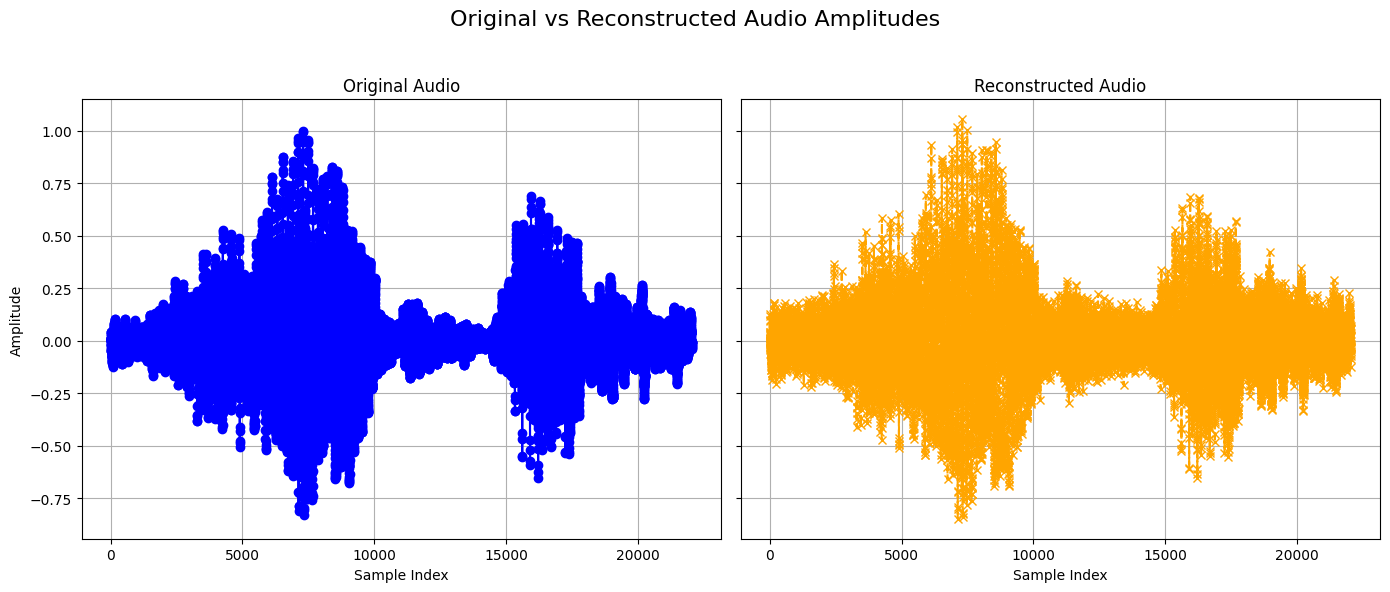

In [52]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot original audio in the first subplot
axes[0].plot(range(len(a)), a, marker='o', linestyle='-', color='blue')
axes[0].set_title('Original Audio')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Amplitude')
axes[0].grid()

# Plot reconstructed audio in the second subplot
axes[1].plot(range(len(reconstructed_audio[:len(a)])), reconstructed_audio[:len(a)], 
             marker='x', linestyle='--', color='orange')
axes[1].set_title('Reconstructed Audio')
axes[1].set_xlabel('Sample Index')
axes[1].grid()

# Add overall title and adjust layout
plt.suptitle('Original vs Reconstructed Audio Amplitudes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

In [58]:
##### Upsample the reconstructed amplitudes to the original length
upsampled_reconstructed_audio = np.interp(
    np.arange(0, len(signal)), 
    np.arange(0, len(reconstructed_audio)), 
    reconstructed_audio
)

# Apply Savitzky-Golay filter to reduce noise
filtered_audio = savgol_filter(upsampled_reconstructed_audio, 100, 3)

# Ensure that highest value is in 16-bit range
audio = filtered_audio * (2**15 - 1) / np.max(np.abs(filtered_audio))
audio = audio.astype(np.int16)

# Play the reconstructed audio
sd.play(audio, sr)
status = sd.wait()  # Wait until sound has finished playing